In [18]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from nnsight import LanguageModel
from utils import SparseAct, load_examples
import torch as t
import plotly.graph_objects as go
from dictionary_learning import AutoEncoder
from dictionary_learning.dictionary import IdentityDict
from ablation import run_with_ablations
from scipy import interpolate
import math
from statistics import stdev

from circuit import get_circuit, load_circuit

In [2]:
device = 'cuda:0'
DEVICE = 'cuda:0'
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map=device, dispatch=True)

start_layer = 2 # explain the model starting here

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# load submodules
submodules = []
if start_layer < 0: submodules.append(model.gpt_neox.embed_in)
for i in range(start_layer, len(model.gpt_neox.layers)):
    submodules.extend([
        model.gpt_neox.layers[i].attention,
        model.gpt_neox.layers[i].mlp,
        model.gpt_neox.layers[i]
    ])

submod_names = {
    model.gpt_neox.embed_in : 'embed'
}
for i in range(len(model.gpt_neox.layers)):
    submod_names[model.gpt_neox.layers[i].attention] = f'attn_{i}'
    submod_names[model.gpt_neox.layers[i].mlp] = f'mlp_{i}'
    submod_names[model.gpt_neox.layers[i]] = f'resid_{i}'

In [4]:
# load dictionaries
dict_id = 10

activation_dim = 512
expansion_factor = 64
dict_size = expansion_factor * activation_dim

feat_dicts = {}
ae = AutoEncoder(activation_dim, dict_size).to(device)
ae.load_state_dict(t.load(f"C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/embed/ae.pt", map_location=device))
feat_dicts[model.gpt_neox.embed_in] = ae

d_model = activation_dim
dict_size = d_model * expansion_factor

for layer in range(len(model.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(device)
    ae.load_state_dict(t.load(f"C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/resid_out_layer{layer}/ae.pt", map_location=device))
    feat_dicts[model.gpt_neox.layers[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(device)
    ae.load_state_dict(t.load(f"C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/attn_out_layer{layer}/ae.pt", map_location=device))
    feat_dicts[model.gpt_neox.layers[layer].attention] = ae

    ae = AutoEncoder(d_model, dict_size).to(device)
    ae.load_state_dict(t.load(f"C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/mlp_out_layer{layer}/ae.pt", map_location=device))
    feat_dicts[model.gpt_neox.layers[layer].mlp] = ae

neuron_dicts = {
    submod : IdentityDict(activation_dim).to(device) for submod in submodules
}


In [5]:
pythia70m = model

pythia70m_embed = pythia70m.gpt_neox.embed_in

pythia70m_resids= []
pythia70m_attns = []
pythia70m_mlps = []
for layer in range(len(pythia70m.gpt_neox.layers)):
    pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
    pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
    pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)
    
dictionaries = {}

d_model = 512
dict_size = 32768

path = "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/"

ae = AutoEncoder(d_model, dict_size).to(DEVICE)
ae.load_state_dict(t.load(path + f"embed/ae.pt", map_location=DEVICE))
dictionaries[pythia70m_embed] = ae


for layer in range(len(pythia70m.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(t.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_resids[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(t.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_attns[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(t.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_mlps[layer]] = ae

In [6]:
def metric_fn_v1(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return logits[0, trg[0]] - logits[0, trg[1]]

In [7]:
clean = "When Mary and John went to the store, John gave a drink to"
patch = "When Mary and John went to the store, Alice gave a drink to"
trg = " Mary"
trg_idx = t.tensor(pythia70m.tokenizer.encode(trg)[0], device=DEVICE)
patch_trg_idx = t.tensor([253], device=DEVICE) # the

In [9]:
# circuit = get_circuit(
#     clean, patch,
#     model,
#     pythia70m_embed, pythia70m_attns, pythia70m_mlps, pythia70m_resids, dictionaries,
#     metric_fn_v1, {"trg": (trg_idx, patch_trg_idx)}
# )

node_threshold = 0.1
edge_threshold = 0.01
n = 144

circuit = load_circuit(
    "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
    "wikipedia3",
    "pythia_70m_deduped",
    node_threshold,
    edge_threshold,
    n
)

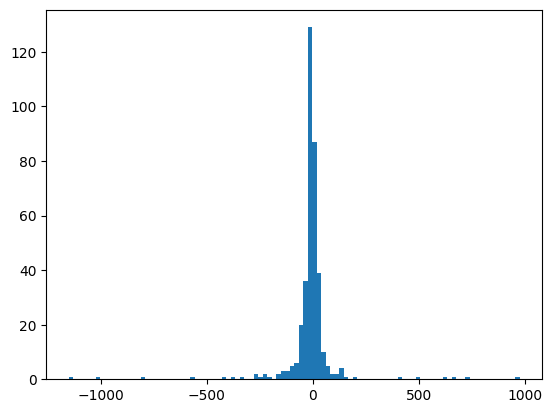

In [25]:
nodes = t.empty(0)
for k, v in circuit[0].items():
    if k != 'y':
        v = v.to_tensor().cpu()
        nz = v.nonzero().squeeze()
        nodes = t.cat((nodes, v[nz]))

from matplotlib import pyplot as plt

plt.hist(nodes[nodes.abs() > 10], bins=100)
plt.show()

In [26]:
with model.trace(patch):
    logits = model.output.save()

print(logits[0][:, -1, :].shape)
logits = logits[0][:, -1, :].squeeze()
perm = t.argsort(logits, descending=True)
p = t.softmax(logits, dim=-1)
for i in range(10):
    print(p[perm[i].item()].item())
    print(perm[i].item())
    print(pythia70m.tokenizer.decode([perm[i].item()]))

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([1, 50304])
0.1829976737499237
253
 the
0.07211925834417343
617
 her
0.05171777307987213
731
 them
0.03711021691560745
6393
 Mary
0.03526845946907997
779
 him
0.03157972916960716
16922
 Alice
0.0294966921210289
247
 a
0.011895938776433468
5332
 Jack
0.011458381079137325
616
 their
0.008285464718937874
521
 his


In [27]:
# use mean ablation
ablation_fn = lambda x: x.mean(dim=0).expand_as(x)

In [28]:
# get m(C) for the circuit obtained by thresholding nodes with the given threshold
def get_fcs(
    model,
    circuit,
    submodules,
    dictionaries,
    ablation_fn,
    thresholds,
    handle_errors = 'default', # also 'remove' or 'resid_only'
):
    clean_inputs = clean
    clean_answer_idxs = trg_idx
    patch_inputs = patch
    patch_answer_idxs = patch_trg_idx

    def metric_fn(model):
        return (
            - t.gather(model.embed_out.output[:,-1,:], dim=-1, index=patch_answer_idxs.view(-1, 1)).squeeze(-1) + \
            t.gather(model.embed_out.output[:,-1,:], dim=-1, index=clean_answer_idxs.view(-1, 1)).squeeze(-1)
        )
    
    circuit = circuit[0]

    with t.no_grad():
        out = {}

        # get F(M)
        with model.trace(clean_inputs):
            metric = metric_fn(model).save()
        fm = metric.value.mean().item()

        out['fm'] = fm

        # get m(∅)
        fempty = run_with_ablations(
            clean_inputs,
            patch_inputs,
            model,
            submodules,
            dictionaries,
            nodes = {
                submod : SparseAct(
                    act=t.zeros(dict_size, dtype=t.bool), 
                    resc=t.zeros(1, dtype=t.bool)).to(device)
                for submod in submodules
            },
            metric_fn=metric_fn,
            ablation_fn=ablation_fn,
        ).mean().item()
        out['fempty'] = fempty

        for threshold in thresholds:
            out[threshold] = {}
            nodes = {
                submod : circuit[submod_names[submod]].abs() > threshold for submod in submodules
            }

            if handle_errors == 'remove':
                for k in nodes: nodes[k].resc = t.zeros_like(nodes[k].resc, dtype=t.bool)
            elif handle_errors == 'resid_only':
                for k in nodes:
                    if k not in model.gpt_neox.layers: nodes[k].resc = t.zeros_like(nodes[k].resc, dtype=t.bool)

            n_nodes = sum([n.act.sum() + n.resc.sum() for n in nodes.values()]).item()
            out[threshold]['n_nodes'] = n_nodes
            
            out[threshold]['fc'] = run_with_ablations(
                clean_inputs,
                patch_inputs,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn,
                ablation_fn=ablation_fn,
            ).mean().item()
            out[threshold]['fccomp'] = run_with_ablations(
                clean_inputs,
                patch_inputs,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn,
                ablation_fn=ablation_fn,
                complement=True
            ).mean().item()
            out[threshold]['faithfulness'] = (out[threshold]['fc'] - fempty) / (fm - fempty)
            out[threshold]['completeness'] = (out[threshold]['fccomp'] - fempty) / (fm - fempty)
    
    return out

In [44]:
#thresholds = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
thresholds = t.logspace(-6, 2, 20, 10).tolist()
outs = {
    'features' :
        get_fcs(
            model,
            circuit,
            submodules,
            feat_dicts,
            ablation_fn=ablation_fn,
            thresholds = thresholds,
        ),
    'features_wo_errs' :
        get_fcs(
            model,
            circuit,
            submodules,
            feat_dicts,
            ablation_fn=ablation_fn,
            thresholds = thresholds,
            handle_errors='remove'
        ),
    'features_wo_some_errs' :
        get_fcs(
            model,
            circuit,
            submodules,
            feat_dicts,
            ablation_fn=ablation_fn,
            thresholds = thresholds,
            handle_errors='resid_only'
        )
}

In [46]:
for setting, subouts in outs.items():
    x_min = max([min(subouts[t]['n_nodes'] for t in thresholds)]) + 1
    x_max = min([max(subouts[t]['n_nodes'] for t in thresholds)]) - 1
    
    xs = [subouts[t]['n_nodes'] for t in thresholds]
    
    fs = [subouts[t]['faithfulness'] for t in thresholds]

    print(f"Setting: {setting}")
    print(f"Min nodes: {x_min}")
    print(f"Max nodes: {x_max}")
    print(f"xs: {xs}")
    print(f"fs: {fs}")

Setting: features
Min nodes: 24
Max nodes: 62153
xs: [62154, 61841, 61464, 60943, 60158, 58987, 57018, 54050, 49442, 42688, 33704, 23159, 12758, 5372, 1900, 664, 228, 85, 43, 23]
fs: [0.39124886052871466, 0.3941659070191431, 0.3392889699179581, 0.3830446672743847, 0.548404740200547, 0.48350045578851414, 0.4902461257976299, 0.5494986326344576, 0.5945305378304466, 0.64102096627165, 0.7622607110300821, 0.42424794895168644, -0.3088422971741112, -0.23482224247948952, -0.3959890610756609, -0.3436645396536007, -0.38359161349134, -0.3290793072014585, -0.3316317228805834, -0.05305378304466728]
Setting: features_wo_errs
Min nodes: 16
Max nodes: 62141
xs: [62142, 61829, 61452, 60931, 60146, 58975, 57006, 54038, 49430, 42676, 33692, 23147, 12746, 5360, 1888, 652, 216, 73, 31, 15]
fs: [-0.8297174111212398, -0.831175934366454, -0.8884229717411122, -0.8041932543299909, -0.7941659070191431, -0.8329990884229718, -0.8160437556973564, -0.8151321786690975, -0.6807657247037374, -0.6862351868732908, -0.4813

In [45]:
# plot faithfulness results
fig = go.Figure()

colors = {
    'features' : 'blue',
    'features_wo_errs' : 'red',
    'features_wo_some_errs' : 'green',
    'neurons' : 'purple',
    # 'random_features' : 'black'
}

y_min = 0
y_max = 1
for setting, subouts in outs.items():
    x_min = max([min(subouts[t]['n_nodes'] for t in thresholds)]) + 1
    x_max = min([max(subouts[t]['n_nodes'] for t in thresholds)]) - 1
    fs = {
        "ioi" : interpolate.interp1d([subouts[t]['n_nodes'] for t in thresholds], [subouts[t]['faithfulness'] for t in thresholds])
    }
    xs = t.logspace(math.log10(x_min), math.log10(x_max), 100, 10).tolist()

    fig.add_trace(go.Scatter(
        x = [subouts[t]['n_nodes'] for t in thresholds],
        y = [subouts[t]['faithfulness'] for t in thresholds],
        mode='lines', line=dict(color=colors[setting]), opacity=0.17, showlegend=False
    ))

    y_min = min(y_min, min([subouts[t]['faithfulness'] for t in thresholds]))
    y_max = max(y_max, max([subouts[t]['faithfulness'] for t in thresholds]))

    fig.add_trace(go.Scatter(
        x=xs,
        y=[ sum([f(x) for f in fs.values()]) / len(fs) for x in xs ],
        mode='lines', line=dict(color=colors[setting]), name=setting
    ))

fig.update_xaxes(type="log", range=[math.log10(x_min), math.log10(x_max)])
fig.update_yaxes(range=[y_min, y_max])

fig.update_layout(
    xaxis_title='Nodes',
    yaxis_title='Faithfulness',
    width=800,
    height=375,
    # set white background color
    plot_bgcolor='rgba(0,0,0,0)',
    # add grey gridlines
    yaxis=dict(gridcolor='rgb(200,200,200)',mirror=True,ticks='outside',showline=True),
    xaxis=dict(gridcolor='rgb(200,200,200)', mirror=True, ticks='outside', showline=True),

)

# fig.show()
fig.write_image('faithfulness.pdf')

In [31]:
# plot completeness results
fig = go.Figure()

colors = {
    'features' : 'blue',
    'features_wo_errs' : 'red',
    'features_wo_some_errs' : 'green',
    'neurons' : 'purple'
}

for setting, subouts in outs.items():

    x_min = max([min(subouts[dataset][t]['n_nodes'] for t in thresholds) for dataset in datasets]) + 1
    x_max = min([max(subouts[dataset][t]['n_nodes'] for t in thresholds) for dataset in datasets]) - 1
    fs = {
        dataset : interpolate.interp1d([subouts[dataset][t]['n_nodes'] for t in thresholds], [subouts[dataset][t]['completeness'] for t in thresholds])
        for dataset in datasets
    }
    xs = t.logspace(math.log10(x_min), math.log10(x_max), 100, 10).tolist()

    for dataset in datasets:
        fig.add_trace(go.Scatter(
            x = [subouts[dataset][t]['n_nodes'] for t in thresholds],
            y = [subouts[dataset][t]['completeness'] for t in thresholds],
            mode='lines', line=dict(color=colors[setting]), opacity=0.17, showlegend=False
        ))
    fig.add_trace(go.Scatter(
        x=xs,
        y=[ sum([f(x) for f in fs.values()]) / len(fs) for x in xs ],
        mode='lines', line=dict(color=colors[setting]), name=setting
    ))

fig.update_xaxes(range=(0,300))
fig.update_yaxes(range=(-.15, 1))

fig.update_layout(
    xaxis_title='Nodes',
    yaxis_title='Faithfulness',
    width=800,
    height=375,
    # set white background color
    plot_bgcolor='rgba(0,0,0,0)',
    # add grey gridlines
    yaxis=dict(gridcolor='rgb(200,200,200)',mirror=True,ticks='outside',showline=True),
    xaxis=dict(gridcolor='rgb(200,200,200)', mirror=True, ticks='outside', showline=True),
)
# fig.show()
fig.write_image('completeness.pdf')

NameError: name 'datasets' is not defined